# Kalman Filter
#### Dano Gillam

In [1]:
from __future__ import division
import numpy as np
from matplotlib  import pyplot as plt
import seaborn
import scipy.io
import matplotlib.pylab as pylab
import skimage.feature
import matplotlib
%matplotlib inline
pylab.rcParams['figure.figsize'] = 10, 7 

### Kalman Filter equations

In [2]:
def next_mu(A,mu_tminus1,K_t,y_t,yhat_t):
    return np.dot(A,mu_tminus1)+np.dot(K_t,(y_t-yhat_t))
def next_cov(K_t,C,covprime_tminus1):
    return (np.eye(np.shape(K_t)[0])-np.dot(K_t,C)) .dot (covprime_tminus1)

def next_yhat(C,A,mu_tminus1):
    return np.dot(C,A) .dot (mu_tminus1)
def next_K(covprime_tminus1,C,S_t):
    return np.dot(covprime_tminus1,C.T) .dot (np.linalg.pinv(S_t))

def get_covprime_tminus1(A,cov_tminus1,Q):
    return np.dot(A,cov_tminus1) .dot(A.T) + Q
def next_S(C,covprime_tminus1,R):
    return np.dot(C,covprime_tminus1) .dot(C.T) + R

In [3]:
def Kalman_Filter(data,A,C,Q,R,init_mu,init_cov):
    N = len(data)
    y = data
    
    mus       = [0]*N   ; mus[0]      =init_mu
    covs      = [0]*N   ; covs[0]     =init_cov
    
    #these must be computed in this order each pass. 
    #They are then used to compute the next mu and cov
    yhats     = [0]*N
    covprimes = [0]*N
    Ss        = [0]*N
    Ks        = [0]*N

    for t in xrange(1,N):
        yhats[t]       = next_yhat(C,A,mus[t-1])
        covprimes[t-1] = get_covprime_tminus1(A,covs[t-1],Q)
        Ss[t]          = next_S(C,covprimes[t-1],R)
        Ks[t]          = next_K(covprimes[t-1],C,Ss[t])
        mus[t]         = next_mu(A,mus[t-1],Ks[t],y[t],yhats[t])
        covs[t]        = next_cov(Ks[t],C,covprimes[t-1])
    return np.array(mus),covs
        
    

In [4]:
#plots an ellipse
def cov_to_pts( cov ):
    circ = np.linspace( 0, 2*np.pi, 100 )
    sf = np.asarray( [ np.cos( circ ), np.sin( circ ) ] )
    [u,s,v] = np.linalg.svd( cov )
    pmat = u*2.447*np.sqrt(s) # 95% confidence
    return np.dot(  pmat, sf )

## First dataset 

In [5]:
def get_random_acceleration_dynamics():    
    # our dynamics are described by random accelerations
    A = np.asarray([
        [ 1, 0, 1, 0, 0.5, 0 ],
        [ 0, 1, 0, 1, 0, 0.5 ],
        [ 0, 0, 1, 0, 1, 0 ],
        [ 0, 0, 0, 1, 0, 1 ],
        [ 0, 0, 0, 0, 1, 0 ],
        [ 0, 0, 0, 0, 0, 1 ] ])

    # our observations are only the position components
    C = np.asarray([
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0]])

    # our dynamics noise tries to force random accelerations to account
    # for most of the dynamics uncertainty
    Q = 1e-2 * np.eye( 6 )
    Q[4,4] = 0.5  # variance of accelerations is higher
    Q[5,5] = 0.5

    # our observation noise
    R = 20 * np.eye( 2 )

    # initial state
    mu_t = np.zeros(( 6, 2 )) # I changed this
    sigma_t = np.eye( 6 )
    return A,C,Q,R,mu_t,sigma_t


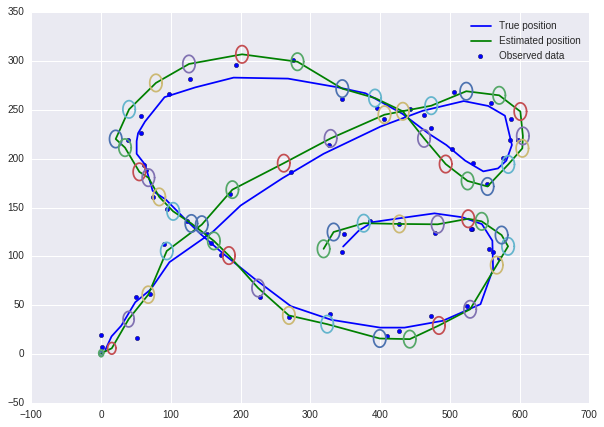

In [6]:
def first_dataset():    
    #get data and plot it
    true_data = scipy.io.loadmat('kfdata.mat')['true_data']
    plt.plot(true_data[:,0],true_data[:,1],'b',label='True position')
    
    #get true_data and plot it
    data = scipy.io.loadmat('kfdata.mat')['data']
    plt.scatter(data[:,0],data[:,1],label='Observed data')

    A,C,Q,R,mu_t,sigma_t = get_random_acceleration_dynamics()
    #perform our Kalman Filter on our data and plot it
    kal_mus,kal_covs = Kalman_Filter(data,A,C,Q,R,mu_t,sigma_t)
    plt.plot(kal_mus[:,0,0],kal_mus[:,0,1],'g',label='Estimated position')
    #plot our covariance ellipses
    
    for i,cov in enumerate(kal_covs):
        X = cov_to_pts(cov[:2,:2])[0]+kal_mus[i,0,0]
        Y = cov_to_pts(cov[:2,:2])[1]+kal_mus[i,0,1]
        plt.plot(X,Y)


    plt.legend(loc='upper right')
    plt.show()
first_dataset()

## Second dataset

##### Load data and perform template matching

In [7]:
def loadnmatch():    
    tmp = scipy.io.loadmat('ball_data.mat')
    frames = tmp['frames']  # frames of our video
    ball = tmp['ball']  # our little template

    data = []
    for i in range( 0, frames.shape[1] ):
        tmp = np.reshape( frames[:,i], (360,243) ).T  # slurp out a frame
        ncc = skimage.feature.match_template( tmp, ball )  # create a normalized cross correlation image
        maxloc = np.unravel_index( tmp.argmax(), tmp.shape )  # find the point of highest correlation
        data.append( maxloc )  # record the results
    data = np.asarray( data )
    return data, frames


##### Movie code

In [8]:
# assumes that "mus" contains a list of Gaussian means, and that "covs" is a list of Gaussian covariances
def play_movie(data,frames,mus=0,covs=0):
    for t in range(0, data.shape[0]):

        tmp = np.reshape( frames[:,t], (360,243) ).T

        plt.figure(1)
        plt.clf()
        plt.imshow( tmp, interpolation='nearest', cmap=matplotlib.cm.gray )
        plt.scatter( data[t][1], data[t][0] )
        plt.scatter( mus[t][0][1], mus[t][0][0],c='red' )

        foo = cov_to_pts( covs[t][0:2,0:2] )

        plt.plot( foo[0,:] + mus[t][0][1], foo[1,:] + mus[t][0][0],'red' )
        
        plt.xlim([1, 360])
        plt.ylim([243,1])

        plt.pause(0.005)
    plt.close()
#play_movie(data,frames)

#### Slides code

In [9]:
def play_slides(data,frames,mus=0,covs=0):    
    for t in [54,56,78,106,107]:

        tmp = np.reshape( frames[:,t], (360,243) ).T
        plt.imshow( tmp, interpolation='nearest', cmap=matplotlib.cm.gray )
        plt.scatter( data[t][1], data[t][0] ,label='our given data')
        plt.scatter( mus[t][0][1], mus[t][0][0],c='red',label='our kalman filter estimate' )

        foo = cov_to_pts( covs[t][0:2,0:2] )

        plt.plot( foo[0,:] + mus[t][0][1], foo[1,:] + mus[t][0][0],'red' )
        plt.legend(bbox_to_anchor=(1.05,1),loc=2, fontsize = 'xx-large')
        plt.xlim([1, 360])
        plt.ylim([243,1])
        plt.show()

#### Adjusted System dynamics

In [10]:
def get_ball_dynamics():    
    # our dynamics are described by random accelerations
    A = np.asarray([
        [ 1, 0, 1, 0, 0.5, 0 ],
        [ 0, 1, 0, 1, 0, 0.5 ],
        [ 0, 0, 1, 0, 1, 0 ],
        [ 0, 0, 0, 1, 0, 1 ],
        [ 0, 0, 0, 0, 1, 0 ],
        [ 0, 0, 0, 0, 0, 1 ] ])

    # our observations are only the position components
    C = np.asarray([
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0]])

    # our dynamics noise tries to force random accelerations to account
    # for most of the dynamics uncertainty
    Q = 1 * np.eye( 6 )# variance of position is higher
    Q[2,2] = 1  # variance of velocity is higher
    Q[3,3] = 1
    Q[4,4] = .0001  # variance of accelerations is low
    Q[5,5] = .0001

    # our observation noise
    R = 5000 * np.eye( 2 )
    #.001,.01,.0001,10000 works well
    # initial state
    mu_t = np.zeros(( 6, 2 )) # I changed this
    mu_t[0] = 150,200
    mu_t[1] = 150,200
    sigma_t = np.eye( 6 )
    return A,C,Q,R,mu_t,sigma_t

#### Kalman filter on the ball

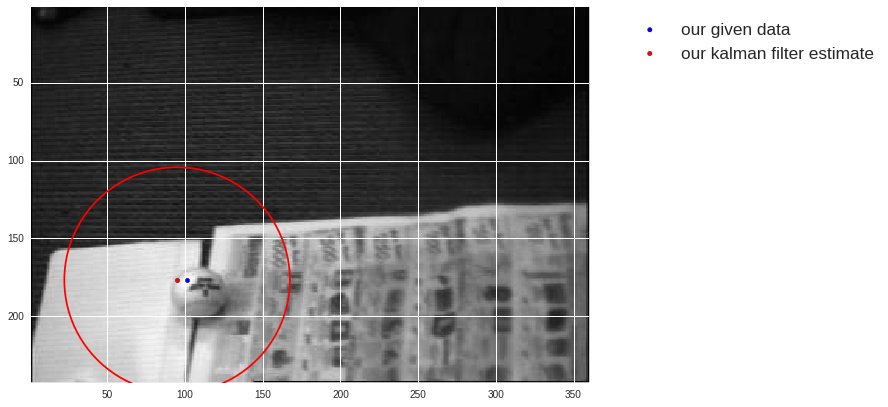

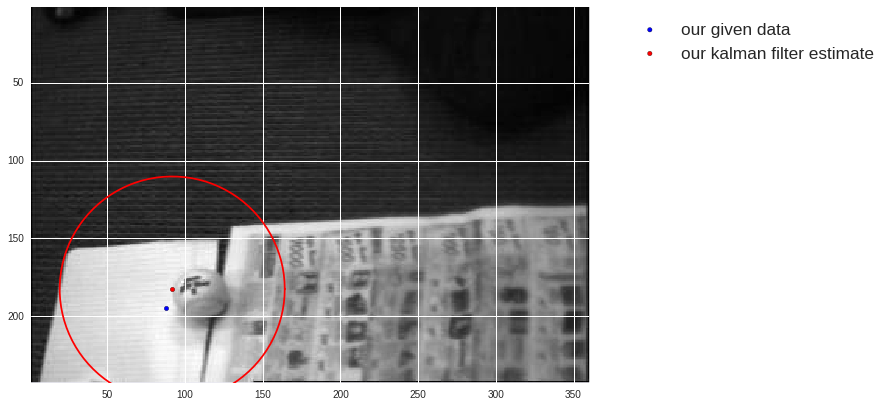

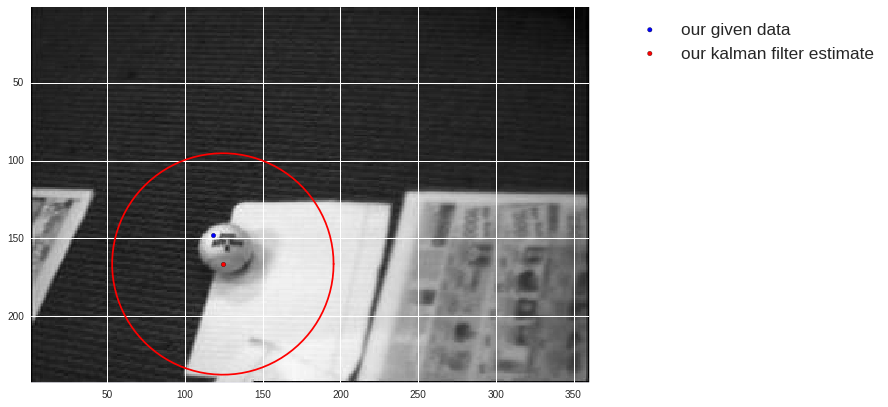

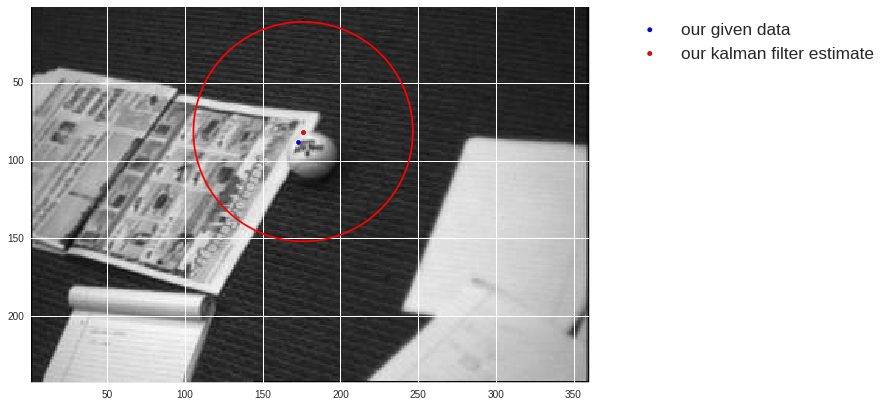

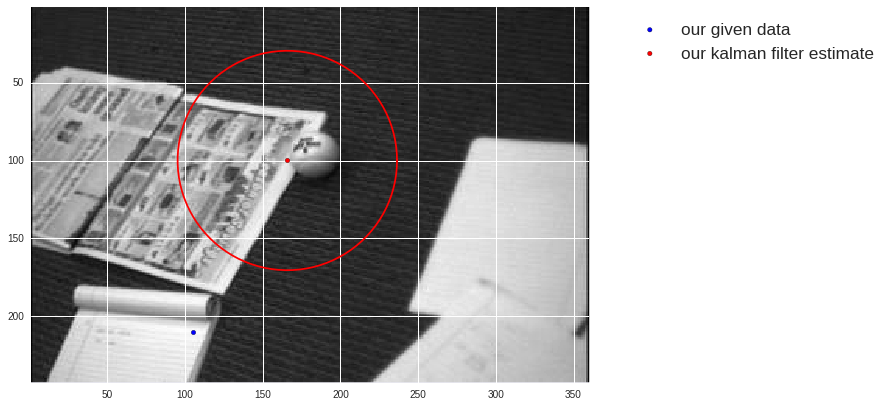

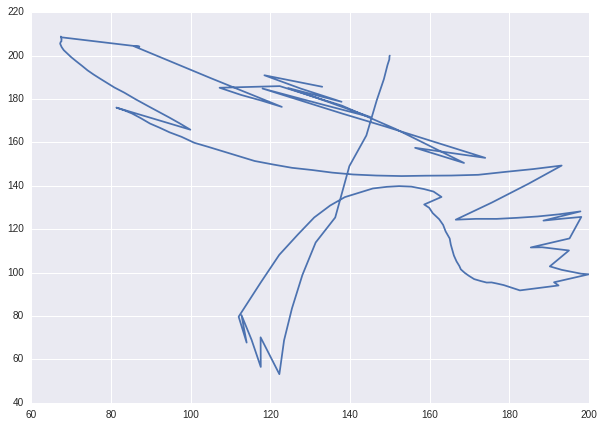

In [11]:
def second_dataset():    
    #get true_data and plot it
    data, frames = loadnmatch()    
    #perform our Kalman Filter on our data and plot it
    A,C,Q,R,mu_t,sigma_t = get_ball_dynamics()
    kal_mus,kal_covs = Kalman_Filter(data,A,C,Q,R,mu_t,sigma_t)
    play_slides(data,frames,kal_mus,kal_covs)
    
    plt.plot(kal_mus[:,0,0],kal_mus[:,0,1],label='Estimated position')
    plt.show()
second_dataset()

### Why I chose these Parameters:
* R was set to be very large to account for the low accuracy of our measurements
* Q was adjusted to give little head to large changes in acceleration. This made the prediction less affected by rapid changes.